
## Installs and imports



In [ ]:
! pip install --upgrade pandas tensorflow_gpu ktrain odfpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 717 kB 5.0 MB/s 
  Created wheel for odfpy: filename=odfpy-1.4.1-py2.py3-none-any.whl size=160692 sha256=2c8d69e2b3f8e668353bd07e386ed870d3f518236051982833aab26eb5504a24
  Stored in directory: /root/.cache/pip/wheels/e2/f4/5d/a68c656235d33455a1d0f78e877acddfa006907a6d52d7e6ee
Successfully built odfpy


In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


**RESTART RUNTIME**

## Load Hindi sentiment analysis dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd 

import os
os.chdir("/content/drive/MyDrive/The-London-Story/Supervised-NLP-tasks/")

df = pd.read_excel ("HINDI_dataset.ods", engine='odf', names=["review", "sentiment"])
df.head()

,review,sentiment
0,गुमनाम है वतन पर मिटने वाले लोग आतन्कवादियों स...,negative
1,ज़ंजीर बदली जा रही थी मैं समझा था रिहाई हो गयी है,negative
2,यूपी में बड़े स्तर पर दंगे करवा सकती है बीजेपी...,negative
3,अंग्रेजी नहीं आती है इसलिए हिन्दी ट्विट ज्यादा...,negative
4,कश्मीर में हो रहा है जल जिहाद ।,negative


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['review'], df['sentiment'], random_state=91)

In [ ]:
print(set(y_train.values))

{'negative', 'positive', 'neutral'}


N.B. ktrain code below is based on the source code [here](https://towardsdatascience.com/text-classification-with-hugging-face-transformers-in-tensorflow-2-without-tears-ee50e4f3e7ed) 

## Create a transformer instance & preprocess the datasets





In [ ]:
import ktrain
from ktrain import text
t = text.Transformer("monsoon-nlp/hindi-bert", maxlen=500, class_names=list(set(y_train.values)))

Downloading:   0%|          | 0.00/572 [00:00<?, ?B/s]

In [ ]:
trn = t.preprocess_train(X_train.to_numpy(), y_train.to_numpy())

preprocessing train...
language: hi
train sequence lengths:
	mean : 16
	95percentile : 27
	99percentile : 30


/usr/local/lib/python3.7/dist-packages/ktrain/utils.py:738: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  "class_names argument was ignored, as they were extracted from string labels in dataset"


Downloading:   0%|          | 0.00/181 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/607k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Is Multi-Label? False


In [ ]:
evalr = t.preprocess_test(X_test.to_numpy(), y_test.to_numpy())

preprocessing test...
language: hi
test sequence lengths:
	mean : 16
	95percentile : 27
	99percentile : 30


## Create a Model and Wrap in Learner

In [ ]:
model = t.get_classifier()

Downloading:   0%|          | 0.00/59.1M [00:00<?, ?B/s]

In [ ]:
learner = ktrain.get_learner(model, train_data=trn, val_data=evalr, batch_size=6)

## Estimate the Learning Rate

simulating training for different learning rates... this may take a few moments...
Epoch 1/3
1134/1134 [==============================] - 221s 177ms/step - loss: 1.0419 - accuracy: 0.4500
Epoch 2/3
1134/1134 [==============================] - 201s 178ms/step - loss: 0.9813 - accuracy: 0.4383
Epoch 3/3
1134/1134 [==============================] - 148s 131ms/step - loss: 288.6625 - accuracy: 0.3392


done.
Visually inspect loss plot and select learning rate associated with falling loss


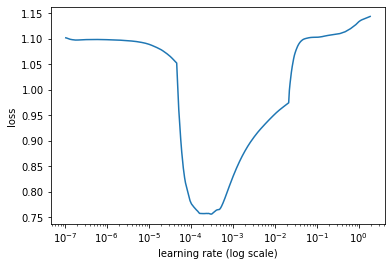

In [ ]:
learner.lr_find(show_plot=True, max_epochs=3)

If you pick a bad learning rate below, learner will remember the bad training. I've purposely included the `model =` and `learner =` lines in this cell to reset you

## Train the model

In [ ]:
model = t.get_classifier()
learner = ktrain.get_learner(model, train_data=trn, val_data=evalr, batch_size=6)
learner.fit_onecycle(1.2e-4, 3)



begin training using onecycle policy with max lr of 0.00012...
Epoch 1/3
1135/1135 [==============================] - 225s 182ms/step - loss: 0.7986 - accuracy: 0.5882 - val_loss: 0.6329 - val_accuracy: 0.6144
Epoch 2/3
1135/1135 [==============================] - 206s 180ms/step - loss: 0.6163 - accuracy: 0.6888 - val_loss: 0.6686 - val_accuracy: 0.6977
Epoch 3/3
1135/1135 [==============================] - 207s 181ms/step - loss: 0.4564 - accuracy: 0.8081 - val_loss: 0.4567 - val_accuracy: 0.8021


## Inspect the Model

In [ ]:
learner.view_top_losses(n=1, preproc=t)

71/71 [==============================] - 8s 58ms/step
----------
id:216 | loss:6.09 | true:neutral | pred:positive)



## Make Predictions on New Data

In [ ]:
predictor = ktrain.get_predictor(learner.model, preproc=t)

In [ ]:
predictor.predict("Hum log saab paapi hain")

1/1 [==============================] - 0s 77ms/step


'positive'

In [ ]:
!pip3 install git+https://github.com/amaiya/eli5@tfkeras_0_10_1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/amaiya/eli5 (to revision tfkeras_0_10_1) to /tmp/pip-req-build-nzxv_pv8
  Running command git clone -q https://github.com/amaiya/eli5 /tmp/pip-req-build-nzxv_pv8
  Running command git checkout -b tfkeras_0_10_1 --track origin/tfkeras_0_10_1
  Switched to a new branch 'tfkeras_0_10_1'
  Branch 'tfkeras_0_10_1' set up to track remote branch 'tfkeras_0_10_1' from 'origin'.
  Created wheel for eli5: filename=eli5-0.10.1-py2.py3-none-any.whl size=106895 sha256=75bb5a56445245dd6b42cb41ed83b59475e0e4bc1a7061600239f63007bfe8e2
  Stored in directory: /tmp/pip-ephem-wheel-cache-tddlzi29/wheels/f8/8c/47/b4cafd3c9519194a489dd614ead1485899d2b34c5adc4198ff
Successfully built eli5


In [ ]:
predictor.explain("Hum log saab paapi hain")

79/79 [==============================] - 5s 67ms/step


In [ ]:
predictor.predict_proba ("Hum log saab paapi hain")

1/1 [==============================] - 0s 128ms/step


array([0.19822161, 0.03361361, 0.76816475], dtype=float32)

In [ ]:
predictor.get_classes()

['negative', 'neutral', 'positive']

## Save and reload the predictor

In [ ]:
predictor.save('/content/drive/MyDrive/Models/hindi_sentiment_predictor')

In [ ]:
reloaded_predictor = ktrain.load_predictor ('/content/drive/MyDrive/Models/hindi_sentiment_predictor')

Test whether the reloaded predictor works

In [ ]:
reloaded_predictor.explain("Hum log saab paapi hain")

79/79 [==============================] - 3s 39ms/step
